# 7.2: Examining `G.fst` with `openFST` 
## (in `python` with `pywrapfst`)

`openFST` has a `python` wrapper called [`pywrapfst`](http://www.openfst.org/twiki/bin/view/FST/PythonExtension) that gives us *most* of the functionality of `openFST` but from inside `python`.

We will also use some custom methods that are in `utils/fst_manipulate/fst_manipulate.py`.

In [1]:
# because of the way `kaldi` installed `openFST` we have to add the path to the python functions here
import sys
sys.path.append("/scratch/kaldi/tools/openfst-1.6.2/lib/python2.7/site-packages")    

from utils.fst_manipulate import fst_manipulate as fstman  # scripts to further manipulate fsts

import pywrapfst as openfst  # the wrapper module
import graphviz as dot   # a wrapper for graphviz, which will allow us to visualize

## read in the `fst`

Using `Fst.read()` we can load the `fst` into an easy-to-read format with the following structure:

 ```
 from_state     to_state    arc_symbol    weight(-log)
 ```

In [2]:
fst_in = openfst.Fst.read("resource_files/fst/animal_fst-2_gram.fst")
print(fst_in)

3	2	<s>	0
0	1	</s>	2.95194
0	4	the	1.34249
0	5	mouse	3.10607
0	6	ate	2.18979
0	7	cheese	3.10607
0	8	cat	2.95194
0	9	and	2.49994
0	10	dog	2.95194
0	11	lion	2.95194
0	12	tyrannosaurus	3.10607
0	13	rex	3.10607
0	14	human	4.20468
0	15	shot	4.20468
0	16	<unk>	2.18979
1	0
2	0	<eps>	1.60944
2	4	the	0.427346
4	0	<eps>	1.76766
4	5	mouse	2.04333
4	7	cheese	2.04333
4	8	cat	1.86265
4	10	dog	1.86265
4	11	lion	1.86265
4	12	tyrannosaurus	2.04333
4	14	human	3.61421
5	0	<eps>	0.810931
5	1	</s>	2.00747
5	4	the	1.48194
5	6	ate	1.82721
5	9	and	1.35206
6	0	<eps>	2.70805
6	4	the	0.0505077
7	0	<eps>	1.25276
7	1	</s>	1.84654
7	9	and	0.519392
8	0	<eps>	0.916291
8	1	</s>	2.11283
8	4	the	1.5873
8	6	ate	1.40741
8	9	and	1.45742
9	0	<eps>	2.39789
9	4	the	0.0695268
10	0	<eps>	0.916291
10	1	</s>	2.11283
10	4	the	1.5873
10	6	ate	1.06486
10	9	and	2.01864
11	0	<eps>	1.09861
11	1	</s>	2.05164
11	6	ate	0.730316
11	9	and	1.97707
12	0	<eps>	1.79176
12	13	rex	0.173406
13	0	<eps>	1.25276
13	1	</s>	1.84654
13	6	ate	0.505155
14

## visualize

By simply calling the variable `fst_in`, this notebook will automatically render the `FST` for visualization.

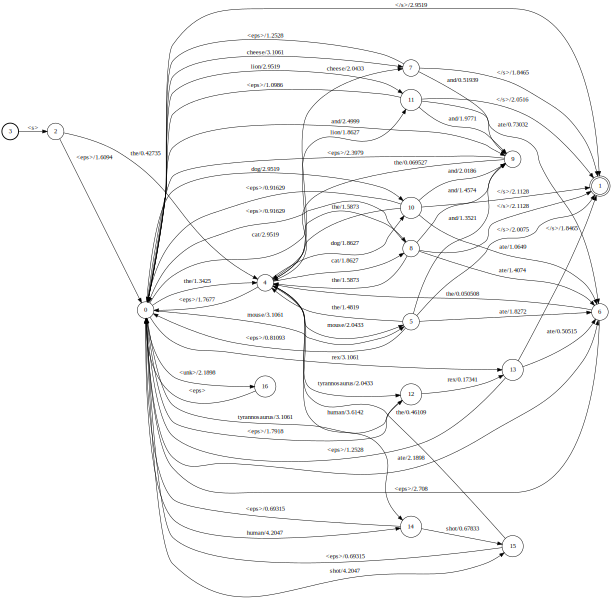

In [34]:
fst_in

## write to `.dot`

We can also write this `fst` into a `.dot` (from `graphviz`) format (in case we want to visualize it outside of this noteboook)

In [3]:
fst_in.draw("resource_files/fst/animal_fst-2_gram.dot")

Unfortunately, the default setting is to write the `.dot` so that the image is in `landscape` format.

In [4]:
%%bash
head resource_files/fst/animal_fst-2_gram.dot

digraph FST {
rankdir = LR;
size = "8.5,11";
label = "";
center = 1;
orientation = Landscape;
ranksep = "0.4";
nodesep = "0.25";
3 [label = "3", shape = circle, style = bold, fontsize = 14]
	3 -> 2 [label = "<s>:<s>", fontsize = 14];


This doesn't visualize well in these notebooks, so the `python` method below will *wrap* both the `FST.draw()` command along with an in-place edit of the `.dot` file to `orientation = Portrait`.

In [5]:
fstman.write_wrapper(
    fst_=fst_in, 
    path_out="resource_files/fst/animal_fst-2_gram.dot"
)    

You may prefer to render the `.dot` format in your browser using a site like http://www.webgraphviz.com/.  Just copy the `.dot` text from `resource_files/fst/animal_fst-2_gram.dot`.

## analyzing the `fst`


This [blog post](http://vpanayotov.blogspot.com/2012/06/kaldi-decoding-graph-construction.html), which we'll revisit next week, has a section about converting our language model to an `FST`.  The relevant image and portion are below:

![sample_g](resource_files/fst/sample_G.png)

```One thing to keep in mind here is that the weights of the FSTs are calculated by negating the natural logarithm of the probabilities, and the quantities given in ARPA file format are base 10 logarithms of probabilities. The WFST produced by arpa2fst is really straightforward but let's look little closer. There is a start node representing the start of an utterance (node 0), separate nodes for each of our "ache", "Cay", "K." vocabulary words (nodes 6, 4 and 5 respectively), a back-off node (1) and a final node(2) for the end of an utterance. Let's for the sake of the example trace a path through the graph corresponding to a bigram - say "<s> ache" bigram. Because there is no such bigram in our toy corpus we are forced to take the route through the back-off node, i.e. the arcs 0-3, 3-1, 1-6. The weight of the first arc is 0 (i.e. 1 when converted to probability), the weight of 3-1 arc is 0.69315, which corresponds to the back-off probability for "<s>" (−ln(10−0.30103)), and the weight 2.0794 of 1-6 arc corresponds to the unigram probability of "ache" (−ln(10−0.9030899)).```

So the format of any `FST`-form of a `2-gram` language model is this:
 - There is a `start` node
    - The weight from `start` node to `<s>` will always be 0
 - There is a `node` for each word in vocabulary (including `<s>` and `</s>`)
    - There will be an `arc` from each `node` that models a "valid" `2-gram`
       - The weight will be `2-gram` probability of $p(to|from)$
    - There will be an `arc` from the `backoff` node
       - The weight will be the `unigram` probability $p(to)$
 - There is a `backoff` node
    - There will be an `arc` from each `word-node`
      - The `arc` `label` will be `<eps>`
      - The weight will be the `backoff` `unigram` probability $p(from)$


`fst_manipulate.py` has a method called `index_fst()` which will parse an existing `FST` and return **TWO** `<dict>`s:
 - `<dict>` that will give you the `state_id` associated with every word along with (1) the `weight`s of any `arc` from another `word-state` and (2) the `weight`s of any `arc` to another `word-state`.
 - `<dict>` that is a lookup from `node_id` to `word`


In [7]:
fst_dict, node_2_word = fstman.index_fst(
    fst_in=fst_in
)

In [8]:
fst_dict

{'</s>': {'state_id': 1,
  'weights_from': {'<eps>': 2.95193696,
   'cat': 2.11282921,
   'cheese': 1.84653735,
   'dog': 2.11282921,
   'lion': 2.05164027,
   'mouse': 2.00746965,
   'rex': 1.84653735},
  'weights_to': {}},
 '<eps>': {'state_id': 0,
  'weights_from': {'<s>': 1.60943794,
   '<unk>': -0.0,
   'and': 2.3978889,
   'ate': 2.70804739,
   'cat': 0.91629076,
   'cheese': 1.25276279,
   'dog': 0.91629076,
   'human': 0.693147242,
   'lion': 1.09861171,
   'mouse': 0.810931385,
   'rex': 1.25276279,
   'shot': 0.693147242,
   'the': 1.76766241,
   'tyrannosaurus': 1.79175889},
  'weights_to': {'</s>': 2.95193696,
   '<unk>': 2.18979073,
   'and': 2.49993968,
   'ate': 2.18979073,
   'cat': 2.95193696,
   'cheese': 3.10607219,
   'dog': 2.95193696,
   'human': 4.2046814,
   'lion': 2.95193696,
   'mouse': 3.10607219,
   'rex': 3.10607219,
   'shot': 4.2046814,
   'the': 1.34249234,
   'tyrannosaurus': 3.10607219}},
 '<s>': {'state_id': 2,
  'weights_from': {},
  'weights_to': {

In [9]:
node_2_word

{0: '<eps>',
 1: '</s>',
 2: '<s>',
 4: 'the',
 5: 'mouse',
 6: 'ate',
 7: 'cheese',
 8: 'cat',
 9: 'and',
 10: 'dog',
 11: 'lion',
 12: 'tyrannosaurus',
 13: 'rex',
 14: 'human',
 15: 'shot',
 16: '<unk>'}

For example, if I wanted to see what `node` represented the word `"tyrannosaurus"` in our `FST`...

In [10]:
fst_dict["tyrannosaurus"]["state_id"]

12

And if I wanted to know what the probability of any **explicitly modeled** `2-gram` (like `"the tyrannosaurus"`)...

In [11]:
fst_dict["tyrannosaurus"]["weights_from"]["the"]

2.04333472

I could also get the same value by trying this...

In [12]:
fst_dict["the"]["weights_to"]["tyrannosaurus"]

2.04333472

But if you look closely at the `<dict>` for `weights_from` for the word `tyrannosaurus`, you'll notice it only has two entries: 
 - `"the"`
 - `<eps>`

In [13]:
fst_dict["tyrannosaurus"]["weights_from"]

{'<eps>': 3.10607219, 'the': 2.04333472}

This is because the **only** explicitly modeled `2-gram` ending in `"tyrannosarus"` is `"the tyrannosaurus"`.  And remember, that `<eps>` is used to help us "backoff" for any unseen `2-gram`s.

So if we tried to look up `"cat tyrannosaurus"`, I'll get a `KeyError`.

In [14]:
fst_dict["tyrannosaurus"]["weights_from"]["cat"]

KeyError: 'cat'

In [ ]:
fst_dict["cat"]["weights_to"]["tyrannousaurus"]

Instead we'd need to look up `"<eps> tyrannosaurus"`.

In [ ]:
fst_dict["tyrannosaurus"]["weights_from"]["<eps>"]

In [ ]:
fst_dict["<eps>"]["weights_to"]["tyrannosaurus"]

We'll use this `fst_dict` a little bit later.  But first, we need to look at two more things we can do with our `FST`:

 1. checking to see if sequence if valid according to our language model
 2. finding the shortest path for a given sequence and calculating its cost

### checking to see if sequence is valid according to language model

Ultimately, we will use an `FST` to determine the most likely transcription of the audio sent as input to our `ASR` pipeline.  For now, we can use the `FST` representing our language model to see how we would need to travel through the `FST` in order to reprent any sequence.

In [15]:
sample_sentence = "the rex ate the human"

`fst_manipulate.py` has a method called `sequence_to_fst()` which will convert any sequence represented as a `<str>` into a "mini"-`FST`.

It takes two arguments:
 - `seq_string` --> the `<str>` of the sequence we want to learn about
 - `lm_fst` --> the `FST` representing our language model; we need this to ensure we correctly map words to indices
 
It will generate a very basic `FST` representing the sequence.

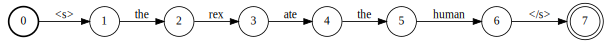

In [16]:
sample_sentence_fst = fstman.sequence_to_fst(
    seq_string=sample_sentence,    
    lm_fst=fst_in                  
)                                 
sample_sentence_fst

We can then [`compose`](http://www.openfst.org/twiki/bin/view/FST/ComposeDoc) a new `FST` which is a combination of our original `FST` (representing our language model) and our "mini"-`FST` (representing our sequence we want to learn about).  

If the sequence we provide **can** be modeled by our language model, then we should get out a resulting `FST`.  And if this `compose` step fails, we know that our language model is incapable of modeling that sequence.

**Note:** Because we have a token representing `<unk>`, we will be able to model any sequence by our language model.

`fst_manipulate.py` has a method called `check_sequence()` which does two things:
 1. calls `sequence_to_fst()` to build the "mini"-`FST`
 2. calls `compose` to build the composed `FST`.

In [17]:
sample_sentence_fst_out = fstman.check_sequence(
    seq_string=sample_sentence, 
    lm_fst=fst_in
)
sample_sentence_fst_out

We can now see, essentially, just the portion of the language model that we need in order to model our sequence.  This means that our language model **can** model this sentence.

### finding the shortest path and calculating its cost

But you'll also notice that there is **more than one** possible path through this `FST`.  So if we want to determine how **likely** this sentence is, we'll need to calculate the cost of the **shortest** path.  This cost will end up represting the **same** thing as the probability of the sequence according to our language model (`2.2 Examining language models`), but the numbers will **not** end up being the same.

**Note:** This is because of `kaldi`-specific steps taken when converting the language model to an `FST`.  But the **relationship** between the cost of two sequences will still represent the same thing (*e.g.* if the cost of one sequence is **larger** than the cost of another sequence, then we know that the first sequence is **less likely**.

`fstmanipulate.py` has a method called `get_shortest_path()` that will return the shortest path through an `FST`.

In [18]:
fstman.get_shortest_path(
    fst_in=sample_sentence_fst_out
)

Now we need to accumulate the cost for each arc to determine the overall cost of the path, which will represent the overall likelihood of the sentence according to our `FST`.

Again, `fstmanipulate.py` has a method to do this: `calculate_cost()`.

In [19]:
fstman.calculate_cost(
    fst_in=sample_sentence_fst_out
)

13.1160345

Remember, that this value is `negative log, base e` ($-ln$), so we need to do a quick conversion to get it out of `ln` space, and convert to a probability.

`fst_manipulate.py` has a method called `convert_neg_log_e()` that will take $e^{-value}$.

In [20]:
fstman.convert_neg_log_e(
    neg_log_e=fstman.calculate_cost(
        fst_in=sample_sentence_fst_out
    )
)

2.0126978941321308e-06

## Comparing likelihoods

If this `FST` is an accurate representation of our language model, then the comparisons that we made in `2.2 Examining language models` should still hold.

### `mouse ate` v. `lion ate`

When we compared these two sequences before, we found that `"lion ate"` was **four times more likely** than `"mouse ate"`.  This shouldn't be surprising because, remember, we built our language model on the sentences below.

In [21]:
cat resource_files/language_model/animal_corpus.txt

the mouse ate the cheese
the cat ate the cheese and the cat ate the mouse
the dog ate the cheese and the dog ate the mouse and the dog ate the cat
the lion ate the cheese and the lion ate the mouse and the lion ate the cat and the lion ate the dog
the tyrannosaurus rex ate the cheese and the tyrannosaurus rex ate the cat and the tyrannosaurus rex ate the dog and the tyrannosaurus rex ate the lion
the human shot the mouse the cat the dog the lion and the tyrannosaurus rex


Let's see if the same relationship between these likelihoods is maintained in our `FST`.

In [22]:
mouse_ate = "mouse ate"
mouse_ate_fst = fstman.check_sequence(        # generates the composed-FST of our sequence and the full FST
    seq_string=mouse_ate,    
    lm_fst=fst_in                  
)
mouse_ate_log_cost = fstman.calculate_cost(   # get the log cost
    fst_in=mouse_ate_fst
)      
mouse_ate_cost = fstman.convert_neg_log_e(    # convert to probability
    neg_log_e=mouse_ate_log_cost
)  
mouse_ate_cost

5.0168836694713655e-06

In [23]:
lion_ate = "lion ate"
lion_ate_fst = fstman.check_sequence(         # generates the composed-FST of our sequence and the full FST
    seq_string=lion_ate,    
    lm_fst=fst_in                  
)
lion_ate_log_cost = fstman.calculate_cost(    # get the log cost
    fst_in=lion_ate_fst
)         
lion_ate_cost = fstman.convert_neg_log_e(     # convert to probability
    neg_log_e=lion_ate_log_cost
)    
lion_ate_cost

1.7528639006650842e-05

In [24]:
lion_ate_cost / mouse_ate_cost

3.493929730385368

Considering the changes `kaldi` made during the conversion, this is close enough.

### `ate the mouse` v. `ate the lion`

If you look back at `2.2 Examining language models`, you'll notice that our `2-gram` language model was *not* able to model the above sequences in such a way to match our intuitions.  

We expected that, since three animals eat the `"mouse"`, but only one animal eats the `"lion"`, then `"ate the mouse"` should be **three times more likely** than `"ate the lion"`.  But this wasn't true.  This had to do with the fact that `"the lion"` appeared one more time than `"the mouse"` in our corpus.

(Recall, we could fix this with a `3-gram` model that modeled `"ate the mouse"` and `"ate the lion"` as a single unit)

In [25]:
cat resource_files/language_model/animal_corpus.txt

the mouse ate the cheese
the cat ate the cheese and the cat ate the mouse
the dog ate the cheese and the dog ate the mouse and the dog ate the cat
the lion ate the cheese and the lion ate the mouse and the lion ate the cat and the lion ate the dog
the tyrannosaurus rex ate the cheese and the tyrannosaurus rex ate the cat and the tyrannosaurus rex ate the dog and the tyrannosaurus rex ate the lion
the human shot the mouse the cat the dog the lion and the tyrannosaurus rex


Not surprisingly, the same relationship between the two sequences that we saw in the language model occur when we run them through the `FST`.

In [26]:
ate_the_mouse = "ate the mouse"
ate_the_mouse_fst = fstman.check_sequence(        # generates the composed-FST of our sequence and the full FST
    seq_string=ate_the_mouse,    
    lm_fst=fst_in                  
)
ate_the_mouse_log_cost = fstman.calculate_cost(   # get the log cost
    fst_in=ate_the_mouse_fst
)      
ate_the_mouse_cost = fstman.convert_neg_log_e(    # convert to probability
    neg_log_e=ate_the_mouse_log_cost
)  
ate_the_mouse_cost

0.0003705430854410317

In [27]:
ate_the_lion = "ate the lion"
ate_the_lion_fst = fstman.check_sequence(         # generates the composed-FST of our sequence and the full FST
    seq_string=ate_the_lion,    
    lm_fst=fst_in                  
)
ate_the_lion_log_cost = fstman.calculate_cost(    # get the log cost
    fst_in=ate_the_lion_fst
)      
ate_the_lion_cost = fstman.convert_neg_log_e(     # convert to probability
    neg_log_e=ate_the_lion_log_cost
)  
ate_the_lion_cost

0.00042474163140828744

### modifying the `FST`

If we wanted to "fix" this problem back in Week 2, we'd have had two options: 

 1. add more data to our corpus and rebuild the `ARPA`-style language model
 2. manually adjust the probability and backoff values in the existing `ARPA`-style language model
 
**Note:** Doing #2 would **no longer** guarantee a probability distribution across the entire language model (*i.e.* all of the probabilities would **no longer** add up to `1.0`), but this isn't really a huge deal, especially if we were in a position where adding more data to the corpus wasn't practical.

But even if we did #2, we'd still have to then rebuild the `FST` representing that language model.  So instead, let's modify the `FST` directly.  

Presumably there are one of three things we'd want to do to an existing `FST` representation of a language model:
 1. add a new word to the `FST`
 2. remove a word from the `FST`
 3. modify the "likelihood" of sequences containing a particular word in the `FST`
   
A few notes about these:

 1. We actually can't add a new word to the `FST` that easily.  This is because the `FST` is built from an existing vocabulary of possible words.  To add a word to the `FST`, we'd have to first rebuild that vocabulary file, then add the new word.  Then modify the `FST`. 
 2. This is actually relatively easy to do.  Since each word has its own `node` in the `FST`, if we remove that `node`, along with all `arc`s to and from that `node`, we'd have removed the word from the language model.  **Note**:  Our language model has **both** `<unk>` modeled **and** `backoff` weights calculated.  So even an unseeen word or `n-gram` **can** get calculated by our `FST`.  So when we "remove" a word, all we can do is remove the explicit modeling of that word in particular `n-gram`s. 
 3. We can do this in one of two ways (or a combination of both ways):
   - simply **increase**/**decrease** the likelihood of an existing `n-gram` containing a particular word
     - *e.g.* if we wanted to increase the likelihood of `"cat food"` but **not** `"cat ate"`
     - in this case, we'd simply need to **increase** the weight of the **one** `arc` from the `cat` `node` to the `food` `node`
   - **increase**/**decrease** the likelihood of a particular word in **all** settings
     - *e.g.* if we wanted to increase the likelihood of `cat` in **all** cases
     - this would require updating **all** `arc`s into the `cat` `node`

The less scientific part about cases #1 and #3, though, is how to determine what `weight` to set for the `arc`s.  And unless we are incredibly careful, we will not longer guarantee a probability distribution across our `FST`.  And while this, in and of itself, won't break our ASR pipeline, it may have unforseen consequences when modeling other sequences.
 
In fact, let this be a warning: any of the above will have impacts throughout the language model, some of which may be unforseen and undesirable.  You've been warned.

So let's see if we can update our `2-gram` `FST` so that `"ate the mouse"` ends up being approximately **three times more likely** than `"ate the lion"`.  We'll do this by updating the `weight`s of existing `arc`s (#3 above).

#### updating `weight`s

`fstmanipulate.py` has a method called `update_weight()` that will update **one** arc's weight at a time.  It will make the changes **in-place**.  Meaning, if you want to keep the original around, you need to make a copy.

In [28]:
%%bash
cat utils/fst_manipulate/fst_manipulate.py | grep -A7 "update_weight("

def update_weight(fst_in, from_word, to_word, new_weight):
    """
    Updates a single weight on a given FST
    :param fst_in: <openfst.Fst> to modify
    :param from_word: <str>
    :param to_word: <str>
    :param: new_weight: <float>
    :return: updated <openfst.Fst>


For example, if we wanted to update the weight of the `arc` from `"tyrannosaurus"` to `"rex"`, we could do that like this....

adding: from_state:12 -> arc:12,weight:99.999 -> to_state:13
adding: from_state:12 -> arc:0,weight:1.79175889 -> to_state:0


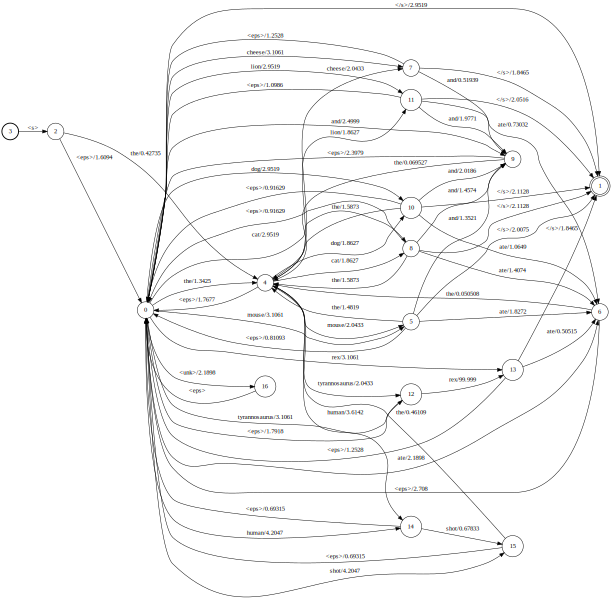

In [29]:
# make a copy of the original
fst_copy = fst_in.copy()
# update the weights of the copy
fstman.update_weight(
    fst_in=fst_copy, 
    from_word="tyrannosaurus", 
    to_word="rex", 
    new_weight=99.999
)

Notice two things:
  1. The printed output says that **two** `arc`s were added.  That's because we were required to **remove** all `arc`s from a particular `state`, then add back the ones we wanted to keep along with the updated one.
  2. If you look at the `arc` from `12` -> `13`, you'll now see the weight of `99.999` for `"rex"`.
  
**Note:** Since we made a **copy** of the `FST` before running `update_weights()`, we can still see the "original" `FST` (without the `weight` of `99.999`) captured by the variable `fst_in`.

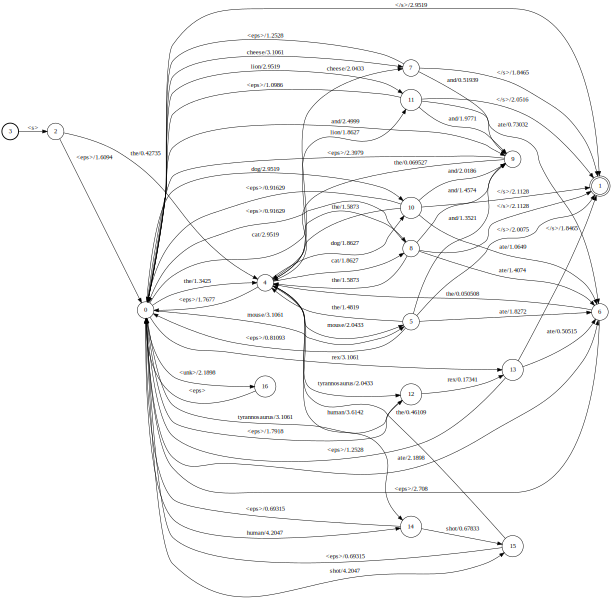

In [30]:
fst_in

#### adding/deleting `arc`s

Even though we won't be using them here, `fst_manipulate.py` has methods for `adding` and `removing` `arc`s as well.  Here is a summary of their usage.

TODO WRITE AND TEST!

Now back to solving our `"ate the {lion,mouse}"` problem...

#### `"ate the {lion,mouse}"`: updating `weight`s


If we look at the two `FST`s for the two sequences, we can see an obvious difference between the two:
 - `5` -> `7`: `"lion"/1.8627` v. `"mouse"/2.0433`
 
**Note:** You may also notice the difference in `weight` of the final `arc` to `"</s>"`.  This is a consequence of the extra steps `kaldi` took in building this `FST`.  We'll ignore it for now and hope it doesn't have a large impact.

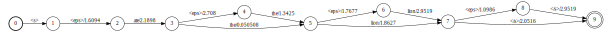

In [42]:
ate_the_lion_fst

In [41]:
ate_the_mouse_fst

Remember, these `weight`s are $-ln$, so a **smaller** number is actually a **higher** likelihood.  Use `convert_neg_log_e()` to see them as probabilities.

In [45]:
lion_prob = fstman.convert_neg_log_e(
    neg_log_e=1.8627
)
lion_prob

0.15525288118240185

In [46]:
mouse_prob = fstman.convert_neg_log_e(
    neg_log_e=2.0433
)
mouse_prob

0.129600323360693

This matches our intuitions because we know that `"lion"` appeared in our corpus **one more time** than `"mouse"`.  So a simple solution would be to **increase** the `weight` of the `"mouse"` arc so that it is equal to the `"lion"` `weight`. 

But remember there are multiple `"mouse"` arcs in our `FST`.

In [50]:
fst_dict["mouse"]

{'state_id': 5,
 'weights_from': {'<eps>': 3.10607219, 'the': 2.04333472},
 'weights_to': {'</s>': 2.00746965,
  '<eps>': 0.810931385,
  'and': 1.35206187,
  'ate': 1.82720721,
  'the': 1.48193693}}

There are **two** `arc`s with `"mouse"` on the label:
  1. from the `backoff` (`"<eps>"`) node
  2. from the `"the"` node
  
So do we only update one?  Or both?

An argument could easily be made for updating **both** `arc`s, but since we really are only trying to handle a **specific** sequence (`"ate the {lion,mouse}"`), we can probably get away with only updating the `arc` from `"the"`.

So first we'll make a copy of `fst_in` for our experiment.

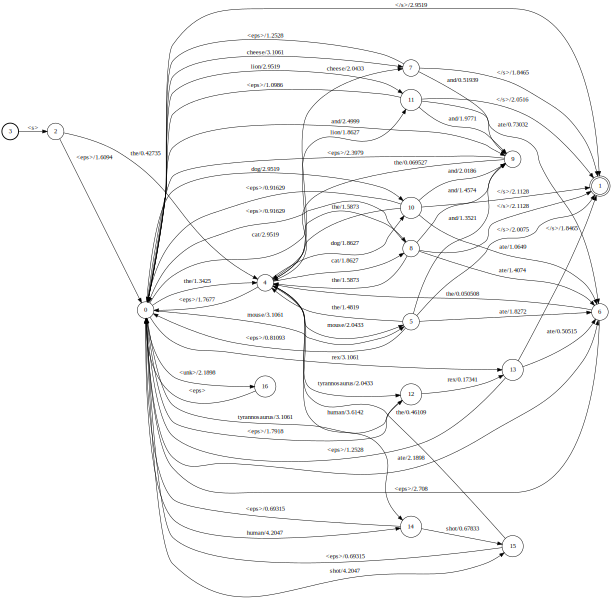

In [48]:
fst_experiment_update_weight = fst_in.copy()
fst_experiment_update_weight

Now let's update the weight for the `arc` from `"the"` to `"mouse"` (in the visualization above, it's the `arc` labeled `"mouse"` from `node 4` to `node 5`) so that it equals the `weight` for the `arc` from `"the"` to `"lion"` (`arc` labeled `"lion"` from `node 4` to `node 11`).

In [53]:
the_lion_weight = fst_dict["the"]["weights_to"]["lion"]
the_lion_weight

1.86265314

adding: from_state:4 -> arc:4,weight:1.86265314 -> to_state:5
adding: from_state:4 -> arc:0,weight:1.76766241 -> to_state:0
adding: from_state:4 -> arc:6,weight:2.04333472 -> to_state:7
adding: from_state:4 -> arc:7,weight:1.86265314 -> to_state:8
adding: from_state:4 -> arc:9,weight:1.86265314 -> to_state:10
adding: from_state:4 -> arc:10,weight:1.86265314 -> to_state:11
adding: from_state:4 -> arc:11,weight:2.04333472 -> to_state:12
adding: from_state:4 -> arc:13,weight:3.61420679 -> to_state:14


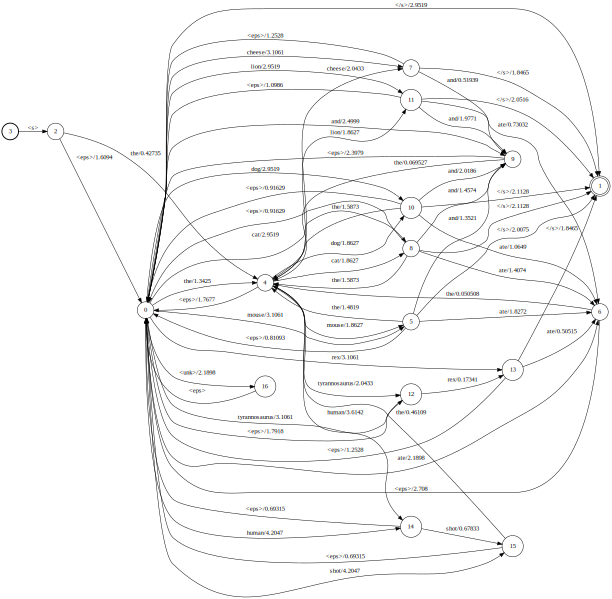

In [54]:
fstman.update_weight(
    fst_in=fst_experiment_update_weight,
    from_word="the",
    to_word="mouse",
    new_weight=the_lion_weight
)

Let's confirm it worked.  We'll make an easy-to-use `<dict>` of our new `FST` with `index_fst()`. 

**Note:** Remember, that returns **two `<dict>s`**, the second of which we don't need right now.

In [56]:
fst_experiment_update_weight_dict, _ = fstman.index_fst(fst_experiment_update_weight)

And now let's make sure that the **only** thing that changed was the `weight` from `"the"` to `"mouse"`.

In [58]:
fst_dict["the"]["weights_to"]

{'<eps>': 1.76766241,
 'cat': 1.86265314,
 'cheese': 2.04333472,
 'dog': 1.86265314,
 'human': 3.61420679,
 'lion': 1.86265314,
 'mouse': 2.04333472,
 'tyrannosaurus': 2.04333472}

In [59]:
fst_experiment_update_weight_dict["the"]["weights_to"]

{'<eps>': 1.76766241,
 'cat': 1.86265314,
 'cheese': 2.04333472,
 'dog': 1.86265314,
 'human': 3.61420679,
 'lion': 1.86265314,
 'mouse': 1.86265314,
 'tyrannosaurus': 2.04333472}

It worked!  Now let's see if the likelihood of the sequences is fixed.  Below are the values for the sequences `"ate the mouse"` and `"ate the lion"` from the original `FST`.

In [60]:
ate_the_mouse_cost

0.0003705430854410317

In [61]:
ate_the_lion_cost

0.00042474163140828744

We didn't do anything to change the cost of `"ate the lion"`, so let's determine the cost of `"ate the mouse"` with our updated `FST`.

In [87]:
# generates the composed-FST of our sequence and the full FST
ate_the_mouse_updated_fst = fstman.check_sequence(  
    seq_string=ate_the_mouse,    
    lm_fst=fst_experiment_update_weight                  
)

In [63]:
# calculate the cost and convert to probability
ate_the_mouse_updated_cost = fstman.convert_neg_log_e(
    neg_log_e=fstman.calculate_cost(
        fst_in=ate_the_mouse_updated_fst
    )
)
ate_the_mouse_updated_cost

0.00044392313938964814

Well we managed to **increase** the likelihood of the sequence to be **more** than that of `"ate the lion"`, but only barely.  What went wrong?  Let's have a look at the `composed` `FST` and compare it to the original.

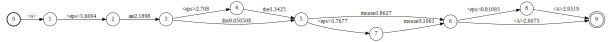

In [86]:
ate_the_mouse_updated_fst

In [64]:
ate_the_mouse_fst

We managed to **increase** the `weight` of `"mouse"`, but it still didn't do what we had hoped.  Let's look at the `composed` `FST` for `"ate the lion"` again.

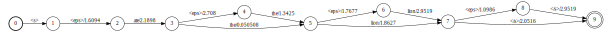

In [65]:
ate_the_lion_fst

The problem actually lies in the `arc` `weight` for `"ate"`.  Right now that `weight` is the **same** for both sequences, but that's not really what we want!  

Intuitively, we want it to be that "eating a mouse" is **more likely** than "eating a lion".  But in the `FST`s above, that's not happening.  

We didn't have this problem with `"lion ate"` and `"mouse ate"`.  See below:

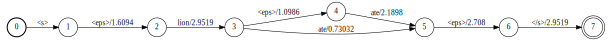

In [72]:
lion_ate_fst

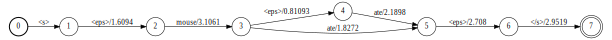

In [73]:
mouse_ate_fst

You can see that the `"ate"` that follows `"mouse"` is much smaller than the `"ate"` that follows `"lion"`.  But that's because we were able to model the `2-gram` `"{lion,mouse} ate"` **explicitly** in our `2-gram` model.  But in the case we're trying to solve now, it's a `3-gram` `"ate the {lion,mouse}"`, and that darn `"the"` is messing everything up!

Because if we look at all the `arc`s leaving the `node` for `"ate"` in our `FST`, we see only two.

In [83]:
fst_dict["ate"]["weights_to"]

{'<eps>': 2.70804739, 'the': 0.0505076647}

That shouldn't be surprising becuase if we look at our corpus again, we'll see that the **only** `2-gram` that we explicitly modeled with `"ate"` is `"ate the"`.

In [66]:
cat resource_files/language_model/animal_corpus.txt

the mouse ate the cheese
the cat ate the cheese and the cat ate the mouse
the dog ate the cheese and the dog ate the mouse and the dog ate the cat
the lion ate the cheese and the lion ate the mouse and the lion ate the cat and the lion ate the dog
the tyrannosaurus rex ate the cheese and the tyrannosaurus rex ate the cat and the tyrannosaurus rex ate the dog and the tyrannosaurus rex ate the lion
the human shot the mouse the cat the dog the lion and the tyrannosaurus rex


So if tried to change the `weight` for the `arc` from `"ate"` to the `"the"`, it would affect `"ate the lion"` and `"ate the mouse"` equally.

And like we discovered in `2.2 Examining language models`, the only way to guarantee we get the outcome we want in this case is to model the `3-gram`s explicitly.

## converting a `3-gram` language model to `FST`

We can follow the same process to convert our `3-gram` language model into an `FST`, but the complexity increases dramatically.  `resource_files/fst` has an `FST` built from our `3-gram` language model that we can look at.

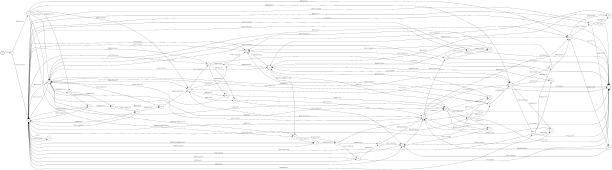

In [32]:
fst_3_gram = openfst.Fst.read("resource_files/fst/animal_fst-3_gram.fst")
fst_3_gram

You can see that even though it has the same vocabulary size as our `2-gram` language model, it's much larger.

In [99]:
num_states_2_gram = len(list(fst_in.states()))
num_states_3_gram = len(list(fst_3_gram.states()))
print("number of states in 2-gram model: {}\nnumber of states in 3-gram model: {}".format(
    num_states_2_gram, num_states_3_gram
    )
)

number of states in 2-gram model: 17
number of states in 3-gram model: 43
